Training Progress:   0%|          | 0/10000 [00:00<?, ?epoch/s]

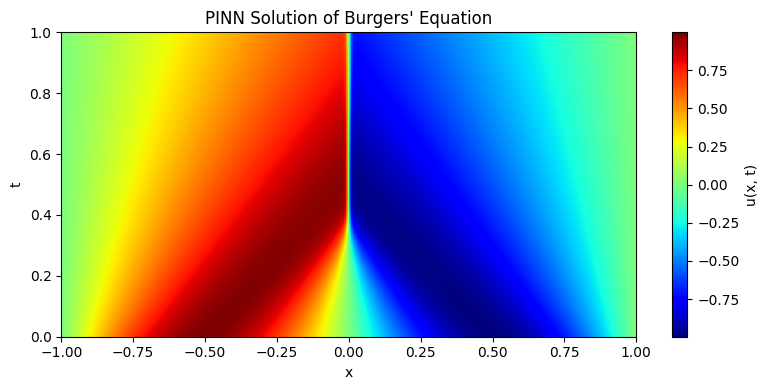

In [3]:
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set viscosity
nu = 0.01 / np.pi

# Define the initial condition
def u0(x):
    return -np.sin(np.pi * x)

# Define the PINN model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16),
            nn.Tanh(),
            nn.Linear(16, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 16),
            nn.Tanh(),
            nn.Linear(16, 1)
        )

    def forward(self, x, t):
        X = torch.cat([x, t], dim=1)
        return self.net(X)

# Domain
x_min = -1
x_max = 1
t_min = 0
t_max = 1

# Collocation points (initial sampling of 500 pairs)
Nf = 5000
x_f_np = np.random.uniform(x_min, x_max, (Nf, 1))
t_f_np = np.random.uniform(t_min, t_max, (Nf, 1))

x_f_base = torch.tensor(x_f_np, dtype=torch.float32).to(device)
t_f_base = torch.tensor(t_f_np, dtype=torch.float32).to(device)

# Sample points
N0 = 200  # Initial condition points
Nb = 100  # Boundary condition points
# Initial condition
x0 = np.random.uniform(x_min, x_max, (N0, 1))
t0 = np.zeros_like(x0)
u0_vals = u0(x0)

# Boundary condition
tb = np.random.uniform(t_min, t_max, (Nb, 1))
xb_left = np.ones_like(tb) * x_min
xb_right = np.ones_like(tb) * x_max
ub = np.zeros_like(tb)

# Combine for supervised loss
x_u = np.vstack([x0, xb_left, xb_right])
t_u = np.vstack([t0, tb, tb])
u_u = np.vstack([u0_vals, ub, ub])

# Convert to tensors
x_u = torch.tensor(x_u, dtype=torch.float32, requires_grad=False).to(device)
t_u = torch.tensor(t_u, dtype=torch.float32, requires_grad=False).to(device)
u_u = torch.tensor(u_u, dtype=torch.float32).to(device)


# Loss functions
def boundary_loss(model, x_u, t_u, u_u):
    u_pred = model(x_u, t_u)
    return torch.mean((u_pred - u_u) ** 2)

def physics_loss(model, x_f, t_f):
    u = model(x_f, t_f)
    u_x = torch.autograd.grad(u, x_f, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_t = torch.autograd.grad(u, t_f, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_f, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    f = u_t + u * u_x - nu * u_xx
    return torch.mean(f**2)

# Initialize model
model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop with tqdm
epochs = 10000
pbar = tqdm(range(epochs), desc="Training Progress", unit="epoch")
for epoch in pbar:
    optimizer.zero_grad()

    # Shuffle indices of collocation pairs
    idx_x = torch.randperm(Nf)
    idx_t = torch.randperm(Nf)
    x_f = x_f_base[idx_x].clone().detach().requires_grad_(True)
    t_f = t_f_base[idx_t].clone().detach().requires_grad_(True)

    # Compute losses
    loss_u = boundary_loss(model, x_u, t_u, u_u)
    loss_f = physics_loss(model, x_f, t_f)
    loss = 10*loss_u + loss_f

    loss.backward()
    optimizer.step()

    # Update progress bar with the latest loss values
    if epoch%100 == 0:
        pbar.set_postfix(Total_Loss=loss.item(), Data_Loss=loss_u.item(), Physics_Loss=loss_f.item())

# Plotting prediction heatmap
x_vals = np.linspace(x_min, x_max, 256)
t_vals = np.linspace(t_min, t_max, 100)
X, T = np.meshgrid(x_vals, t_vals)
X_tensor = torch.tensor(X.flatten(), dtype=torch.float32).view(-1, 1).to(device)
T_tensor = torch.tensor(T.flatten(), dtype=torch.float32).view(-1, 1).to(device)

with torch.no_grad():
    U_pred = model(X_tensor, T_tensor).cpu().numpy()

U = U_pred.reshape(T.shape)

plt.figure(figsize=(8, 4))
plt.imshow(U, extent=[x_min, x_max, t_min, t_max], origin='lower', aspect='auto', cmap='jet')
plt.colorbar(label='u(x, t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title("PINN Solution of Burgers' Equation")
plt.tight_layout()
plt.show()


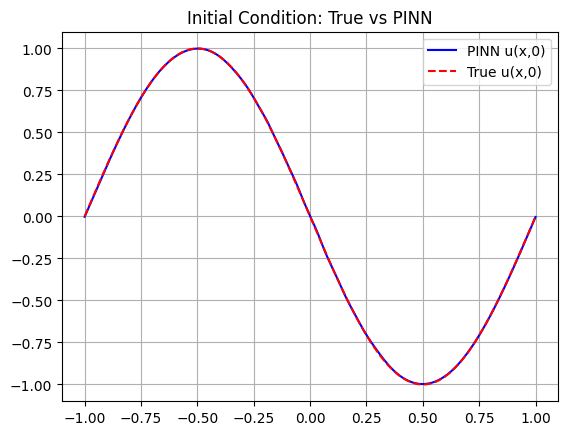

In [6]:
# Check initial condition approximation
x_init = torch.linspace(-1, 1, 200).view(-1, 1).to(device)
t_init = torch.zeros_like(x_init).to(device)

with torch.no_grad():
    u_init_pred = model(x_init, t_init).cpu().numpy()

plt.plot(x_init.cpu(), u_init_pred, label='PINN u(x,0)',color='blue')
plt.plot(x_init.cpu(), u0(x_init.cpu().numpy()), '--', label='True u(x,0)',color ='red')
plt.legend()
plt.grid()
plt.title("Initial Condition: True vs PINN")
plt.show()
